# 互评作业二：网页浏览行为关联规则挖掘

姓名：

学号：

代码仓库地址：

任务: 分析用户在网站上的浏览行为数据，挖掘潜在的跳转规律，为网站提供优化导航结构的建议。

数据集: [UCI ML Repository - Anonymous Microsoft Web Data](http://archive.ics.uci.edu/ml/datasets/Anonymous+Microsoft+Web+Data)

关联规则挖掘：

1. 数据预处理: 清洗数据，处理缺失值，提取用户浏览记录。

2. 数据探索性分析: 分析最常被访问的页面、页面访问量分布等。

3. 关联规则挖掘: 使用Apriori算法或FP-growth算法，根据用户浏览记录计算频繁项集和关联规则。

4. 结果评估: 计算关联规则的支持度、置信度和提升度，得出强关联规则。

5. 结果分析与应用: 分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

# 一、数据集格式及相关信息

## 1.1 相关信息

数据集名称："Anonymous web data from www.microsoft.com"

创建者：Jack S. Breese, David Heckerman, Carl M. Kadie
       Microsoft Research, Redmond WA, 98052-6399, USA
       breese@microsoft.com, heckerma@microsoft.com, carlk@microsoft.com
       
捐赠者: Breese, Heckerman, & Kadie

日期：November 1998

数据源自 1998 年 2 月一周时间内的点击，记录了 $38000$ 个匿名的、随机挑选的用户在一周内浏览的网页。

用户被使用顺序的数字作为标识，如 User #14988；而网页被使用它的标题（e.g. "NetShow for PowerPoint"）和 URL（e.g. "/stream"）作为标识。

实例数量：训练集 $32711$，测试集 $5000$。每一个实例表示网站的一个匿名的、随机抽取的用户。

属性（Attributed）：共 $294$ 个。每一个属性是一个 www.microsoft.com 网站的 area（"vroot"）。

## 1.2 格式

数据是一种基于 ASCII 的稀疏数据格式被称为“DST”。数据文件的每一行用一个字母开头提示这一行的类型。共有 $3$ 种类型：

1. 属性行（Attribute lines, A）。举个例子，比如 `A,1277,1,"NetShow for PowerPoint","/stream"`，这其中：
    - `A` 表示这是一个属性行
    - `1277` 是属性对于网站相应区域的 ID 数字（也被称为 Vroot）
    - `1` 应当被忽略掉
    - `"NetShow for PowerPoint"` 是 Vroot 的标题
    - `"/stream"` 是相对于 `http://www.microsoft.com` 的 URL 地址
2. Case 和 Vote 行。对于每一个用户，有一个 case 行紧跟着 $0$ 个或多个 vote 行。
    - 例子：
```
C,"10164",10164
V,1123,1
V,1009,1
V,1052,1
```
    - `C` 表示这是一个 case 行
    - `10164` 是一个用户的 case ID 号
    - `V` 表示这个 case 的 vote 行
    - `1123`、`1009`、`1052` 是一个用户浏览的 Vroot 的属性 ID
    - `1` 应当被忽略
    

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# 二、数据预处理

本部分内容：清洗数据，处理缺失值，提取用户浏览记录。

## 2.1 数据清洗

首先检查数据格式是否有误，然后把属性和用户分离开来。构建网页信息表 `attribute.csv` 和用户浏览记录表 `case_and_vote.csv`。

In [5]:
attribute = []
case_and_vote = []

with open("/kaggle/input/anonymous-microsoft-web-data-data-set/anonymous-msweb.data", "r", encoding="utf-8") as f:
    for line in f.readlines():
        if line[0] == 'A':
            attribute.append(line)
        elif line[0] == 'C' or line[0] == 'V':
            case_and_vote.append(line)
            
with open("/kaggle/working/attribute.csv", "w", encoding="utf-8") as f:
    f.write("ACV,A_ID,01,A_Title,A_URL" + "\n")
    for i, item in enumerate(attribute):
        f.write(item)

with open("/kaggle/working/case_and_vote.csv", "w", encoding="utf-8") as f:
    f.write("ACV,C_ID/V_ID,C_ID/V_01" + "\n")
    for i, item in enumerate(case_and_vote):
        f.write(item)


查看一下分开的 `csv` 文件。

In [6]:
with open("/kaggle/working/attribute.csv", "r", encoding="utf-8") as f:
    dfa = pd.read_csv(f)
    print(dfa)

with open("/kaggle/working/case_and_vote.csv", "r", encoding="utf-8") as f:
    dfc = pd.read_csv(f)
    print(dfc)

    ACV  A_ID  01                          A_Title        A_URL
0     A  1287   1          International AutoRoute   /autoroute
1     A  1288   1                          library     /library
2     A  1289   1  Master Chef Product Information  /masterchef
3     A  1297   1                  Central America    /centroam
4     A  1215   1         For Developers Only Info   /developer
..   ..   ...  ..                              ...          ...
289   A  1219   1    Corporate Advertising Content         /ads
290   A  1030   1                Windows NT Server    /ntserver
291   A  1182   1                          Fortran     /fortran
292   A  1100   1                  MS in Education   /education
293   A  1210   1                      SNA Support  /snasupport

[294 rows x 5 columns]
       ACV  C_ID/V_ID  C_ID/V_01
0        C      10001      10001
1        V       1000          1
2        V       1001          1
3        V       1002          1
4        C      10002      10002
...     ..

## 2.2 数据清洗

去除两个 csv 文件中的 `nan` 值，检查是否有用户没浏览网站但是在本数据中的情况。

事实上，下面的代码证明了两个 csv 文件中均无 `nan` 值，且不存在有用户没有浏览网站的情况。

In [7]:
with open("/kaggle/working/attribute.csv", "r", encoding="utf-8") as f:
    dfa = pd.read_csv(f)
    print(dfa)
print(dfa.isna().sum())

with open("/kaggle/working/case_and_vote.csv", "r", encoding="utf-8") as f:
    dfc = pd.read_csv(f)
    print(dfc)
print(dfc.isna().sum())
for i in range(len(dfc)):
    if i >= 1 and dfc.iloc[i,0] == 'C' and dfc.iloc[i-1,0] == 'C':
        print(f"用户 {i-1} 没有浏览任何网站！")

    ACV  A_ID  01                          A_Title        A_URL
0     A  1287   1          International AutoRoute   /autoroute
1     A  1288   1                          library     /library
2     A  1289   1  Master Chef Product Information  /masterchef
3     A  1297   1                  Central America    /centroam
4     A  1215   1         For Developers Only Info   /developer
..   ..   ...  ..                              ...          ...
289   A  1219   1    Corporate Advertising Content         /ads
290   A  1030   1                Windows NT Server    /ntserver
291   A  1182   1                          Fortran     /fortran
292   A  1100   1                  MS in Education   /education
293   A  1210   1                      SNA Support  /snasupport

[294 rows x 5 columns]
ACV        0
A_ID       0
01         0
A_Title    0
A_URL      0
dtype: int64
       ACV  C_ID/V_ID  C_ID/V_01
0        C      10001      10001
1        V       1000          1
2        V       1001          

## 2.3 提取用户浏览记录

### 2.1.1 属性数据提取

新的属性数据保存在 `website` 字典中，需要组织成如下格式：

```python
{A_ID: [A_ID, A_Title, A_URL]}
```

### 2.1.2 用户数据提取

新的用户浏览数据保存在 `visit` 字典中，需要组织成如下格式：

```python
{C_ID: [V_ID_0, V_ID_1, ..., V_ID_n]}
```

下面的代码把浏览记录和属性提取出来，检查是否有重复的属性和用户，并查看前 $10$ 个数据是否有误。

In [8]:
website, visit = {}, {}
for i in range(len(dfa)):
    a_id = dfa.iloc[i,1]
    a_title = dfa.iloc[i, 3]
    a_url = dfa.iloc[i, 4]
    if website.get(a_id, -1) != -1:
        print("数据中有重复的属性！")
    website[a_id] = [a_id, a_title, a_url]
    if i == 10:
        print(website)

        
for i in range(len(dfc)):
    c_or_v = dfc.iloc[i,0]
    if c_or_v == 'C':
        c_id = dfc.iloc[i, 1]
        if visit.get(c_id, -1) != -1:
            print("数据中有重复的用户！")
        visit[c_id] = []
    elif c_or_v == 'V':
        v_id = dfc.iloc[i, 1]
        visit[c_id].append(v_id)
    else:
        raise f"第 {i} 行出现错误！第一个字符不为 C 或 V！"
    if i == 10:
        print(visit)

print("数据无误！")

{1287: [1287, 'International AutoRoute', '/autoroute'], 1288: [1288, 'library', '/library'], 1289: [1289, 'Master Chef Product Information', '/masterchef'], 1297: [1297, 'Central America', '/centroam'], 1215: [1215, 'For Developers Only Info', '/developer'], 1279: [1279, 'Multimedia Golf', '/msgolf'], 1239: [1239, 'Microsoft Consulting', '/msconsult'], 1282: [1282, 'home', '/home'], 1251: [1251, 'Reference Support', '/referencesupport'], 1121: [1121, 'Microsoft Magazine', '/magazine'], 1083: [1083, 'MS Access Support', '/msaccesssupport']}
{10001: [1000, 1001, 1002], 10002: [1001, 1003], 10003: [1001, 1003, 1004]}
数据无误！


# 三、数据探索性分析

数据中共有 294 个属性（网站）
数据中共有 32711 个用户
用户浏览到过的网站共有 285 个
用户没浏览任何网站的共有 0 个
所有用户共计浏览次数 98654 次
网站平均点击量为 335.56 次
人均浏览网页数为 3.02 个
点击量最高的前 20 个网站条形图及数据：
[(1008, 10836), (1034, 9383), (1004, 8463), (1018, 5330), (1017, 5108), (1009, 4628), (1001, 4451), (1026, 3220), (1003, 2968), (1025, 2123), (1035, 1791), (1040, 1506), (1041, 1500), (1032, 1446), (1037, 1160), (1030, 1115), (1038, 1110), (1020, 1087), (1000, 912), (1007, 865)]


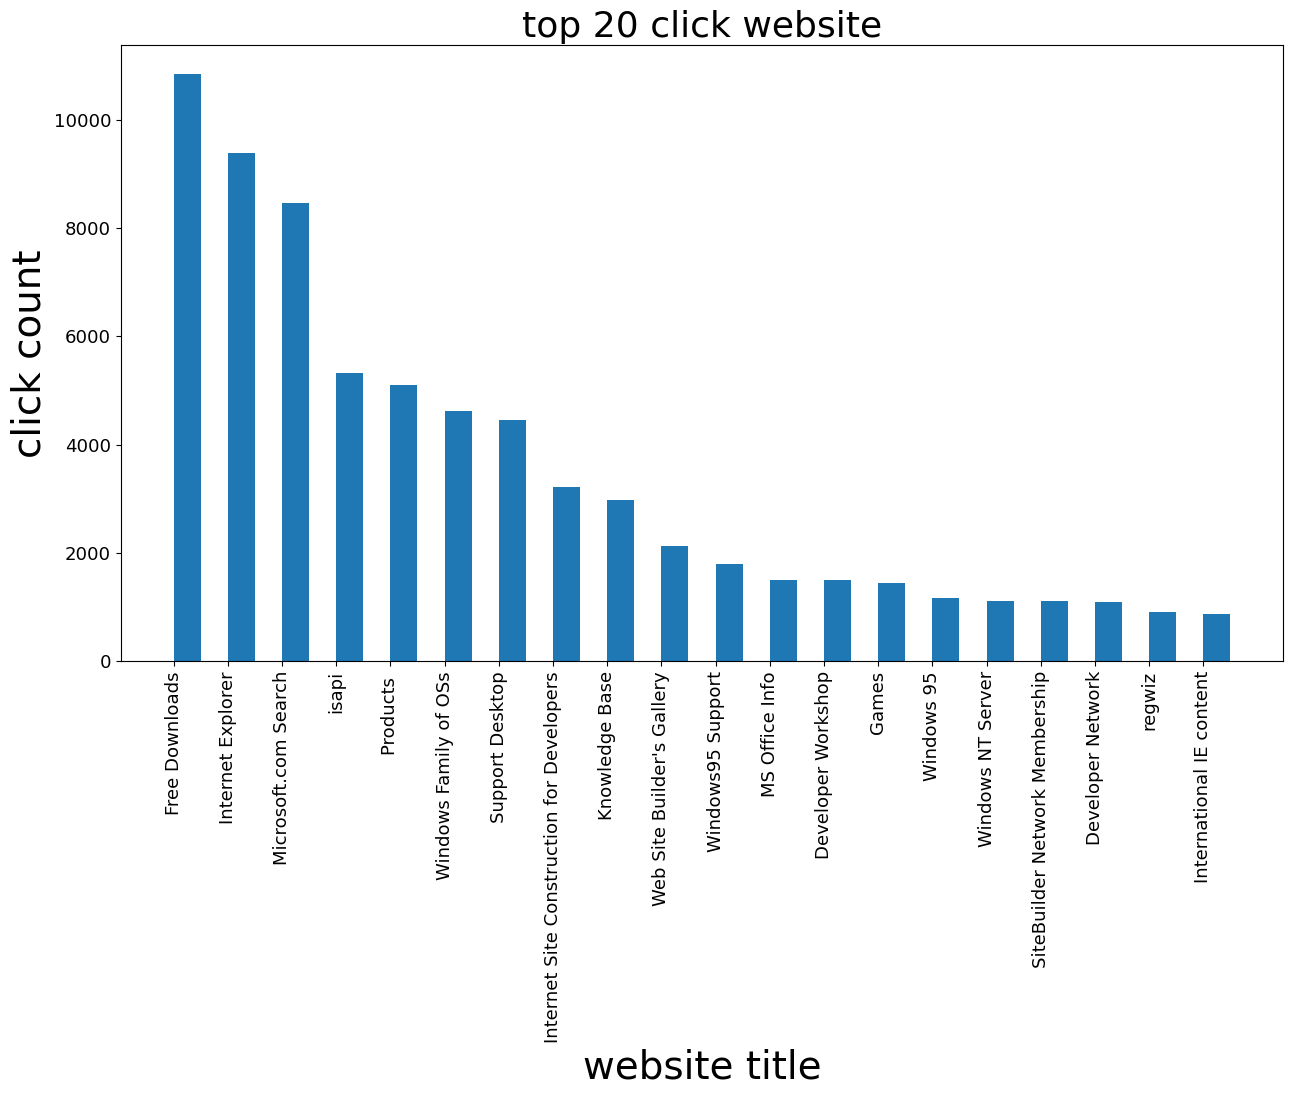

所有网站点击量分布盒图：


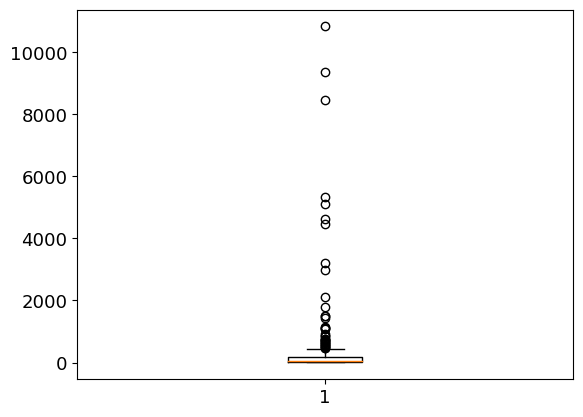

In [9]:
print(f"数据中共有 {len(website.keys())} 个属性（网站）")
print(f"数据中共有 {len(visit.keys())} 个用户")

website_visited = {}
for k in visit.keys():
    for i in range(len(visit[k])):
        website_visited[visit[k][i]] = website_visited.get(visit[k][i], 0) + 1
print(f"用户浏览到过的网站共有 {len(website_visited.keys())} 个")

cnt = 0
for k in visit.keys():
    if len(visit[k]) == 0:
        cnt += 1
print(f"用户没浏览任何网站的共有 {cnt} 个")

cnt = 0
for k in visit.keys():
    cnt += len(visit[k])
print(f"所有用户共计浏览次数 {cnt} 次")
print(f"网站平均点击量为 {(cnt / len(website.keys())):.2f} 次")
print(f"人均浏览网页数为 {(cnt / len(visit.keys())):.2f} 个")

print(f"点击量最高的前 20 个网站条形图及数据：")

n = 20
sorted_website_visited = sorted(website_visited.items(), key=lambda x: x[1], reverse=True)
print(sorted_website_visited[:n])

x, y = [], []
for i in range(n):
    x.append(website[sorted_website_visited[i][0]][1])
    y.append(sorted_website_visited[i][1])
# 中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 13
# 设置图大小
plt.figure(figsize=(15,8))
plt.bar(x,y,width=0.5,bottom=0,align='edge',linewidth=2)

# 绘制标题
plt.title(f"top {n} click website",size=26)

# 设置轴标签
plt.xlabel("website title",size=28)
plt.ylabel("click count",size=28)
plt.xticks(range(len(x)), x, rotation=90)

plt.show()

print(f"所有网站点击量分布盒图：")
click = [*website_visited.values()]
plt.boxplot(click)
plt.show()

可以发现，最常被访问的网站为 Free Downloads，且上面的盒图分布并不均匀。

# 四、关联规则挖掘

采用 apriori 算法进行关联规则挖掘。以下为 apriori 算法。

辅助函数中包含三个函数。第一个函数 `loadDataSet()` 创建了一个用于测试的简单数据集，另外两个函数分别是 `createC1()` 和 `scanD()`。

函数 `createC1()` 将构建集合 C1。C1 是大小为 $1$ 的所有候选项集的集合。Apriori 算法首先构建集合 C1，然后扫描数据集来判断这些只有一个元素的项集是否满足最小支持度的要求。那些满足最低要求的项集构成集合 L1。而 L1 中的元素相互组合构成 C2，C2 再进一步过滤变为 L2。

因此算法需要一个函数 `createC1()` 来构建第一个候选项集的列表 C1。由于算法一开始是从输入数据中提取候选项集列表，所以这里需要一个特殊的函数来处理，而后续的项集列表则是按一定的格式存放的。这里使用的格式就是 Python 中的 frozenset 类型。frozenset 是指被“冰冻”的集合，就是说它们是不可改变的，即用户不能修改它们。这里必须要使用 frozenset 而不是 set 类型，因为之后必须要将这些集合作为字典键值使用，使用 frozenset 可以实现这一点，而 set 却做不到。

首先创建一个空列表 C1，它用来存储所有不重复的项值。接下来遍历数据集中的所有点击记录。对每一条记录，遍历记录中的每一个项。如果某个点击项没有在 C1 中出现，则将其添加到 C1 中。这里并不是简单地添加每个点击项，而是添加只包含该点击项的一个列表（也就是说，C1 是一个集合的集合，如 $\{\{0\},\{1\},\{2\},\dots \}$，每次添加的都是单个项构成的集合 $\{0\}$ 、$\{1\}$ 、$\{2\}$、...）。这样做的目的是为每个点击项构建一个集合。因为在 Apriori 算法的后续处理中，需要做集合操作。Python 不能创建只有一个整数的集合，因此这里实现必须使用列表。这就是使用一个由单物品列表组成的大列表的原因。最后，对大列表进行排序并将其中的每个单元素列表映射到 `frozenset()`，最后返回 frozenset 的列表。

第二个辅助函数是 `scanD()`，它有三个参数，分别是数据集、候选项集列表 Ck 以及感兴趣项集的最小支持度 minSupport。该函数用于从 C1 生成 L1。另外，该函数会返回一个包含支持度值的字典以备后用。`scanD()` 函数首先创建一个空字典 `ssCnt`，然后遍历数据集中的所有点击记录以及 C1 中的所有候选集。如果 C1 中的集合是记录的一部分，那么增加字典中对应的计数值。这里字典的键就是集合。当扫描完数据集中的所有项以及所有候选集时，就需要计算支持度。不满足最小支持度要求的集合不会输出。函数也会先构建一个空列表，该列表包含满足最小支持度要求的集合。下一个循环遍历字典中的每个元素并且计算支持度。如果支持度满足最小支持度要求，则将字典元素添加到 retList 中。可以使用语句 `retList.insert(0,key)` 在列表的首部插入任意新的集合。当然也不一定非要在首部插入，这只是为了让列表看起来有组织。函数最后返回最频繁项集的支持度 supportData。

两个函数 `aprioriGen()` 与 `apriori()`。其中主函数是 `apriori()`，它会调用 `aprioriGen()` 来创建候选项集Ck。

函数 `aprioriGen()` 的输入参数为频繁项集列表 Lk 与项集元素个数 k，输出为 Ck。举例来说，该函数以 $\{0\}, \{1\}, \{2\}$ 作为输入，会生成 $\{0,1\}$、$\{0,2\}$ 以及 $\{1,2\}$。要完成这一点，首先创建一个空列表，然后计算 Lk 中的元素数目。接下来，比较 Lk 中的每一个元素与其他元素，这可以通过两个 for 循环来实现。紧接着，取列表中的两个集合进行比较。如果这两个集合的前面 $k-2$ 个元素都相等，那么就将这两个集合合成一个大小为 $k$ 的集合。这里使用集合的并操作来完成，在 Python 中对应操作符|。

上面的 $k-2$ 有点让人疑惑。接下来再进一步讨论细节。当利用 $\{0\}, \{1\}, \{2\}$ 构建 $\{0,1\}$、$\{0,2\}$ 以及 $\{1,2\}$ 时，这实际上是将单个项组合到一块。现在如果想利用 $\{0,1\}$、$\{0,2\}$ 以及 $\{1,2\}$ 来创建三元素项集，应该怎么做？如果将每两个集合合并， 就会得到 $\{0,1,2\}$、$\{0,1,2\}$、$\{0,1,2\}$。也就是说，同样的结果集合会重复 $3$ 次。接下来需要扫描三元素项集列表来得到非重复结果，我们要做的是确保遍历列表的次数最少。现在，如果比较集合 $\{0,1\}$、$\{0,2\}$ 以及 $\{1,2\}$ 的第 $1$ 个元素并只对第 $1$ 个元素相同的集合求并操作，又会得到什么结果？$\{0, 1, 2\}$，而且只有一次操作！这样就不需要遍历列表来寻找非重复值。

上面所有的操作都被封装在 `apriori()` 函数中。给该函数传递一个数据集以及一个支持度，函数会生成候选项集的列表，这通过首先创建 C1 然后读入数据集将其转化为 D (集合列表)来完成。程序中使用 `map` 函数将 `set()` 映射到 `dataSet` 列表中的每一项。接下来，使用 `scanD()` 函数来创建 L1，并将 L1 放入列表 L 中。L 会包含 L1、L2、L3…。现在有了 L1，后面会继续找 L2，L3…，这可以通过 while 循环来完成，它创建包含更大项集的更大列表，直到下一个大的项集为空。重述一下工作流程：首先使用 `aprioriGen()` 来创建 Ck，然后使用 `scanD()` 基于 Ck 来创建 Lk。Ck 是一个候选项集列表，然后 `scanD()` 会遍历 Ck，丢掉不满足最小支持度要求的项集。Lk 列表被添加到 L，同时增加 k 的值，重复上述过程。最后，当 Lk 为空时，程序返回 L 并退出。

函数 `generateRules()` 是主函数，它调用其他两个函数。其他两个函数是 `rulesFromConseq()` 和 `calcConf()`，分别用于生成候选规则集合以及对规则进行评估。

函数 `generateRules()` 有 $3$ 个参数：频繁项集列表、包含那些频繁项集支持数据的字典、最小可信度阈值。函数最后要生成一个包含可信度的规则列表，后面可以基于可信度对它们进行排序。这些规则存放在 bigRuleList 中。如果事先没有给定最小可信度的阈值，那么默认值设为 $0.7$。`generateRules()` 的另两个输入参数正好是函数 `apriori()` 的输出结果。该函数遍历 L 中的每一个频繁项集并对每个频繁项集创建只包含单个元素集合的列表 H1。因为无法从单元素项集中构建关联规则，所以要从包含两个或者更多元素的项集开始规则构建过程。如果从集合 $\{0,1,2\}$ 开始，那么 H1 应该是 $[\{0\},\{1\},\{2\}]$。如果频繁项集的元素数目超过 $2$，那么会考虑对它做进一步的合并。具体合并可以通过函数 `rulesFromConseq()` 来完成，后面会详细讨论合并过程。如果项集中只有两个元素，那么使用函数 `calcConf()` 来计算可信度值。

我们的目标是计算规则的可信度以及找到满足最小可信度要求的规则。所有这些可以使用函数 `calcConf()` 来完成，而其余代码都用来准备规则。函数会返回一个满足最小可信度要求的规则列表，为了保存这些规则，需要创建一个空列表 prunedH。接下来，遍历 H 中的所有项集并计算它们的可信度值。可信度计算时使用 supportData 中的支持度数据。通过导入这些支持度数据，可以节省大量计算时间。如果某条规则满足最小可信度值，那么将这些规则输出到屏幕显示。通过检查的规则也会被返回，并被用在下一个函数 `rulesFromConseq()` 中。同时也需要对列表 brl 进行填充，而 brl 是前面通过检查的 bigRuleList。

为从最初的项集中生成更多的关联规则，可以使用 `rulesFromConseq()` 函数。该函数有 $2$ 个参数：一个是频繁项集，另一个是可以出现在规则右部的元素列表 H。函数先计算H中的频繁集大小 m。接下来查看该频繁项集是否大到可以移除大小为 m 的子集。如果可以的话，则将其移除。可以使用函数 `aprioriGen()` 来生成 H 中元素的无重复组合。该结果会存储在 Hmp1 中，这也是下一次迭代的 H 列表。Hmp1 包含所有可能的规则。可以利用 `calcConf()` 来测试它们的可信度以确定规则是否满足要求。如果不止一条规则满足要求，那么使用 Hmp1 迭代调用函数 `rulesFromConseq()` 来判断是否可以进一步组合这些规则。


In [10]:
def loadDataSet():
    return [[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], [2, 5]]
def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if not item in C1:
                C1.append(item)
    C1.sort()
    for i in range(len(C1)):
        C1[i] = [C1[i]]
    return list(map(frozenset, C1))

def scanD(D, Ck, minSupport):
    ssCnt = {}
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                if can not in ssCnt: ssCnt[can]=1
                else: ssCnt[can] += 1
    numItems = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key]/numItems
        if support >= minSupport:
            retList.insert(0,key)
        supportData[key] = support
    return retList, supportData

def aprioriGen(Lk, k): #creates Ck
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i+1, lenLk): 
            L1 = list(Lk[i])[:k-2]; L2 = list(Lk[j])[:k-2]
            L1.sort(); L2.sort()
            if L1==L2: #if first k-2 elements are equal
                retList.append(Lk[i] | Lk[j]) #set union
    return retList

def apriori(dataSet, minSupport = 0.5):
    C1 = createC1(dataSet)
    D = list(map(set, dataSet))
    L1, supportData = scanD(D, C1, minSupport)
    L = [L1]
    k = 2
    while (len(L[k-2]) > 0):
        Ck = aprioriGen(L[k-2], k)
        Lk, supK = scanD(D, Ck, minSupport)#scan DB to get Lk
        supportData.update(supK)
        L.append(Lk)
        k += 1
    return L, supportData

def generateRules(L, supportData, minConf=0.7):  #supportData is a dict coming from scanD
    bigRuleList = []
    for i in range(1, len(L)):#only get the sets with two or more items
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            if (i > 1):
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList         

def calcConf(freqSet, H, supportData, brl, minConf=0.7):
    prunedH = [] #create new list to return
    for conseq in H:
        conf = supportData[freqSet]/supportData[freqSet-conseq] #calc confidence
        lift = conf / supportData[conseq]
        if conf >= minConf: 
            print(freqSet-conseq,'-->',conseq,'conf:',conf, 'lift:', lift)
            brl.append((freqSet-conseq, conseq, conf, lift))
            prunedH.append(conseq)
    return prunedH

def rulesFromConseq(freqSet, H, supportData, brl, minConf=0.7):
    m = len(H[0])
    if (len(freqSet) > (m + 1)): #try further merging
        Hmp1 = aprioriGen(H, m+1)#create Hm+1 new candidates
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)
        if (len(Hmp1) > 1):    #need at least two sets to merge
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)

接下来使用上面的 apriori 类做关联规则挖掘，根据用户浏览记录计算频繁项集和关联规则。

先看一下数据集的前 $10$ 组数据

In [11]:
dataSet = [*visit.values()]
dataSet[:10]

[[1000, 1001, 1002],
 [1001, 1003],
 [1001, 1003, 1004],
 [1005],
 [1006],
 [1003, 1004],
 [1007],
 [1004],
 [1008, 1009],
 [1010, 1000, 1011, 1012, 1013, 1014]]

# 五、结果评估

根据用户浏览记录计算频繁项集和关联规则，计算关联规则的支持度、置信度和提升度，得出强关联规则。

调用 `apriori()` 函数和 `generateRules()` 函数，求得 L、SuppData 与 rules。

接下来在最小支持度为 $0.05$，最小置信度为 $0.25$ 时，计算上述值。

In [12]:
L, suppData = apriori(dataSet, minSupport=0.05)

print("频繁项集及其支持度 >= 0.05 的全部项集及支持度为：")
for k in suppData.keys():
    if suppData[k] >= 0.05:
        print(k, suppData[k])

print("\n满足支持度 >= 0.05 且置信度 >= 0.25 时强关联规则及其置信度与提升度为：")
rules = generateRules(L, suppData, minConf=0.25)

频繁项集及其支持度 >= 0.05 的全部项集及支持度为：
frozenset({1001}) 0.1360704350218581
frozenset({1003}) 0.09073400385191525
frozenset({1004}) 0.2587203081532206
frozenset({1008}) 0.33126471217633213
frozenset({1009}) 0.14148145883647703
frozenset({1017}) 0.1561554217235792
frozenset({1018}) 0.162942129558864
frozenset({1025}) 0.06490171501941243
frozenset({1026}) 0.09843783436764392
frozenset({1034}) 0.2868454036868332
frozenset({1035}) 0.05475222402250007
frozenset({1001, 1003}) 0.05521078536272202
frozenset({1008, 1009}) 0.07792485708171563
frozenset({1008, 1018}) 0.07306410687536302
frozenset({1008, 1017}) 0.06123322429763688
frozenset({1008, 1004}) 0.06043838464125218
frozenset({1008, 1034}) 0.16080217663782825
frozenset({1034, 1004}) 0.053284827733789855
frozenset({1001, 1018}) 0.0594295496927639

满足支持度 >= 0.05 且置信度 >= 0.25 时强关联规则及其置信度与提升度为：
frozenset({1018}) --> frozenset({1001}) conf: 0.3647279549718574 lift: 2.6804349887855374
frozenset({1001}) --> frozenset({1018}) conf: 0.4367557852168052 lift:

# 六、结果分析与应用

分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

不妨将点击量前二十的都设置快速导航超链接，而对于上文中强关联规则满足支持度 $\geq 0.05$，置信度 $\geq 0.25$ 的规则，则特设一个超链接即可。